In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
import pandas as pd

In [2]:
# Name of the file we want to read. 
# Remember, "Measurement.ttbin" files read all the files in sequence 'Measurement'
file = "C:/Users/HP/Downloads/TimeTags_RaulAir_2024-10-25_172331.ttbin"

In [3]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
Has data? -> True


In [4]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2024-10-25 17:23:31 +0200
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

### Some useful code for obtaining the timestamps on each channel

In [5]:
data = fr.getData(10)
# Reads the next n_events and returns the buffer object with the specified number of timetags.
print(fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

print(data.getTimestamps())
# Returns: Event timestamps in picoseconds for all chosen channels.
print(data.getChannels())
# Returns: Channel number for each detected event.

print(data.tGetData)
# Returns: The data-stream time position when the TimeTagStream or FileWriter started data acquisition.
print(data.tStart)


data = fr.getData(4)
print(fr.hasData())
print(data.getTimestamps())
print(data.getChannels())

print(fr.getData(1).getTimestamps()-fr.getData(1).getTimestamps())

True
[87705500731037194 87705500765531323 87705500929747074 87705501037051308
 87705501130994590 87705501156436446 87705501252597764 87705501261486571
 87705501264997646 87705501329589781]
[1 1 2 1 1 1 1 2 2 1]
87705501426499534
87705500631040000
True
[87705501426499534 87705501604217693 87705501661176310 87705501706948100]
[1 1 2 2]
[-36162992]


In [6]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

# measure photon antibunching
corr_ch1 = 1 # first photon channel for antibunching measurements
corr_ch2 = 2 # second photon channel for antibunching measurements
bwcorr = 1000 # 1 ns
nbins = 1000

cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])

virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
virtual_tagger.waitForCompletion()

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")

Rate of counts channel 1 (counts/sec) : 8003.999108212611
Rate of counts channel 2 (counts/sec) : 4305.408941877971


In [7]:
fr = FileReader(file)

acc_list = []
n = 10000
treshold = np.mean(cr.getData())*1e-12
print(treshold, "\n")
t_ant = 0

while (fr.hasData()):
    data = fr.getData(n)
    
    ts = data.getTimestamps()
    ch = data.getChannels()
    
    data_raw = np.array([ch, ts])
    
    # Restructure into columns (one for each channel)
    data_ch1 = data_raw[1, np.where(data_raw[0,:] == 1)].copy() # Canal 1
    data_ch2 = data_raw[1, np.where(data_raw[0,:] == 2)].copy() # Canal 2
    
    # Creating an empty array the size of the largest dataset
    data_ch = np.zeros([2, max(data_ch1.shape[1], data_ch2.shape[1])])
    
    # Filling the channel columns with the respective data (one of them will always fall short)
    data_ch[0, :data_ch1.shape[1]] += data_ch1[0]
    data_ch[1, :data_ch2.shape[1]] += data_ch2[0]
    
    # Check we get all data
    #print(data_ch1.size, data_ch2.size, data_ch1.size+data_ch2.size)
    
    delta_t = abs(ts[-1] - ts[0])
    rate = n / delta_t
    
    if (rate > treshold):
        acc_list.append(data_ch - t_ant)
        # print("guardem")
    else:
        t_ant += delta_t
        print("no guardem")
        print(rate)

6.1547040250452905e-09 

no guardem
6.120433878184063e-09
no guardem
6.055434027894538e-09
no guardem
5.737506054844065e-09
no guardem
5.727176346449014e-09
no guardem
5.815465468733041e-09
no guardem
5.603001761676801e-09
no guardem
5.8994685533818726e-09
no guardem
5.887543421951142e-09
no guardem
5.779310779840916e-09
no guardem
5.1928876925083645e-09
no guardem
5.197760333850422e-09
no guardem
6.033948604231834e-09
no guardem
5.7502733177088215e-09
no guardem
5.493031054403625e-09
no guardem
6.14792717863474e-09
no guardem
5.289167882343123e-09
no guardem
5.7730495938606e-09
no guardem
5.246136689244987e-09
no guardem
5.298261914839582e-09
no guardem
5.81960790778198e-09
no guardem
5.55555699852198e-09
no guardem
4.73538547861332e-09
no guardem
4.784582413619381e-09
no guardem
6.043842061751175e-09
no guardem
6.039236075484224e-09
no guardem
5.601464865694292e-09
no guardem
6.109797381237569e-09
no guardem
5.789972263003321e-09
no guardem
5.3011868929125286e-09
no guardem
5.6890886

## Convert back into numpy array

In [8]:
total_len = sum(len(acc_list[i][0]) for i in range(len(acc_list)))
acc = np.zeros([total_len, 2])
index = 0

for i in range(len(acc_list)):
    for j in range(len(acc_list[i][0])):
        acc[index,:] = [acc_list[i][0][j], acc_list[i][1][j]]
        index += 1
        
df = pd.DataFrame(acc)

In [9]:
df

,0,1
0,8.770550e+16,8.770550e+16
1,8.770550e+16,8.770550e+16
2,8.770550e+16,8.770550e+16
3,8.770550e+16,8.770550e+16
4,8.770550e+16,8.770550e+16
...,...,...
19160461,9.006890e+16,-5.508224e+13
19160462,9.006890e+16,-5.508224e+13
19160463,9.006890e+16,-5.508224e+13
19160464,9.006890e+16,-5.508224e+13


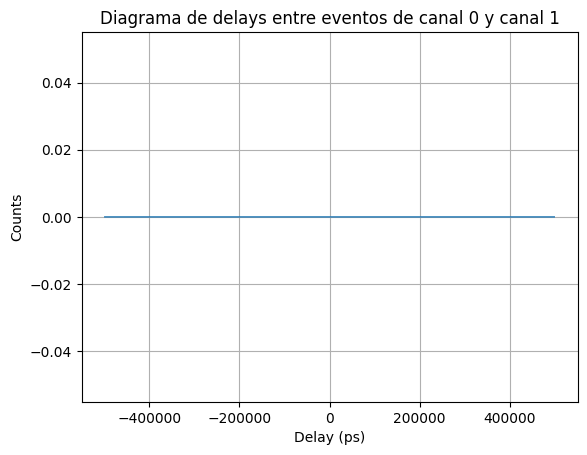

In [34]:
# Variables de entrada
bin_width = 1000      # Anchura del bin en picosegundos
nbin = 1000          # Número total de bins

# Rango máximo de delays a considerar
max_delay = bin_width * nbin / 2

# Extrae los tiempos de llegada de cada canal, ignorando ceros
times_channel_0 = df[0].values
times_channel_1 = df[1].values

# Inicializa una lista para almacenar los delays
delay_matrix = []

# Iterar sobre eventos del canal 0, ignorando ceros
for t0 in times_channel_0:
    if t0 == 0:
        continue  # Saltar eventos en canal 0 que son ceros
    for t1 in times_channel_1:
        if t1 == 0:
            continue  # Saltar eventos en canal 1 que son ceros
        
        delay = t0 - t1

        # Si el delay cae dentro del rango de bineado, guárdalo
        if -max_delay <= delay <= max_delay:
            print("Hola")
            delay_matrix.append(delay)
        # Si el delay supera el máximo, termina la comparación con t1
        elif delay > max_delay:
            break

# Convierte la lista de delays a un array de Numpy para optimizar operaciones
delay_matrix = np.array(delay_matrix)

# Define los bins para el histograma
bins = np.arange(-max_delay, max_delay + bin_width, bin_width)

# Graficar el histograma de delays
plt.hist(delay_matrix, bins=bins, histtype='step')
plt.xlabel("Delay (ps)")
plt.ylabel("Counts")
plt.title("Diagrama de delays entre eventos de canal 0 y canal 1")
plt.grid(True)
plt.show()